# Control theory. Course introduction.

## TP3. Controllability and Observability
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP2.ipynb)    

The completed notebooks should be **submitted via the corresponding Moodle assignments before the beginning of the next session.**

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

## Code template

In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T) 

def PID(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0):
    z0 = np.array([[0.0]])
    x_a =  np.block([[x0.reshape(-1,1)],[z0]])
    M = np.eye(x0.shape[0]) + Kd*B @ C
    A_a = np.block([[np.linalg.inv(M) @ (A - Kp * B @ C), -Ki * np.linalg.inv(M) @ B ], [C, np.array([0.0])]])
    B_a =  np.block([[Kp * np.linalg.inv(M) @ B ], [np.array([1.0])]])
    D_a = np.block([[np.linalg.inv(M) @ D],[np.array([[0.0]])]])
    C_a = np.block([C, np.array([[0.0]])])
    return OpenLoopInputOutputSystem(A_a, B_a, D_a, C_a, r_func, w_func, T, x_a.flatten()).T

Text(0, 0.5, 'Position ')

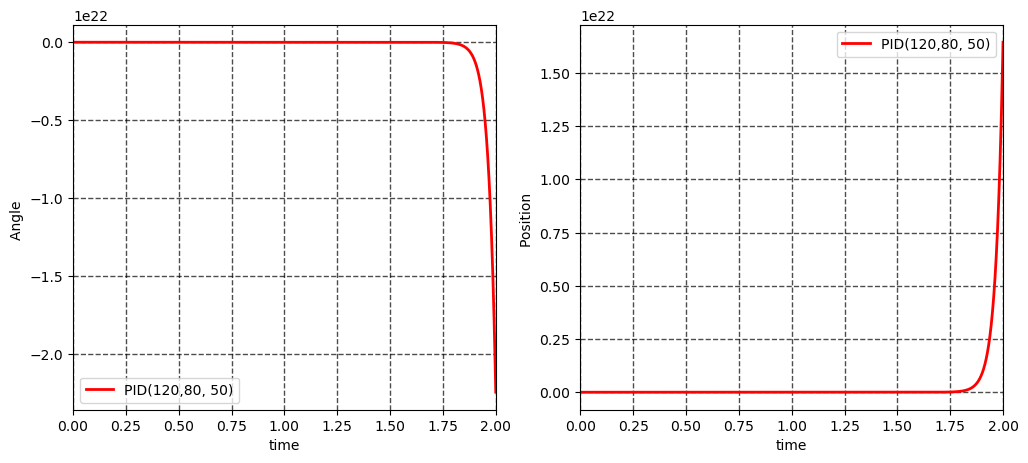

In [25]:
import sympy as sp
from matplotlib.pyplot import *
# Answer to EX1 q1 using symbolic calculus
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = B

x0 = np.array([0,
               0,
               0,
               0])  # initial state

MatC = np.array([[0,0,1,0]]) # Let us assume that we measure only theta
y_ref = 1 # and we want to track constant reference equal to 1 rad. The latter correspond a state responce if the system

Kp= 120;
Ki = 80;
Kd = 50;

t0 = 0 # Initial time 
tf = 2 # Final time
T = np.linspace(t0, tf, 1000) 

def w_func(t):
       return 1.0# Disturbance input

def r_func(t):
       return 0.0# Disturbance input


solution = PID(A, B, D, MatC , Kp, Ki, Kd, r_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[:,2]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[:,0]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

## Ex 1. Duality of Controllability and Observability

Prove that a pair of matrices (A,B) is controllable if and only if a pair of matrices (A^T, B^T) is observable.

ANSWER: If $A\in\mathbb{R}^{n\times n}$ and $B\in\mathbb{R}^{n\times m}$.
The controllability matrix is
$$
\mathcal C(A,B)=\big[B\;AB\;A^2B\;\cdots\;A^{n-1}B\big].
$$
The pair $(A,B)$ is controllable if and only if $\operatorname{rank}(\mathcal C(A,B))=n$.

Considering $(A^T,B^T)$ as a pair for observability. Its observability matrix is
$$
\mathcal O(A^T,B^T)=\begin{bmatrix}
B^T\\
B^TA\\
B^T(A^2)\\
\vdots\\
B^T(A^{n-1})
\end{bmatrix}.
$$
Which is the transpose of the controllability matrix:
$$
\mathcal O(A^T,B^T)=\mathcal C(A,B)^T.
$$
Therefore,
$$
\operatorname{rank}(\mathcal O(A^T,B^T))
=\operatorname{rank}(\mathcal C(A,B)^T)
=\operatorname{rank}(\mathcal C(A,B)).
$$
Since $(A,B)$ controllable $\iff \operatorname{rank}(\mathcal C(A,B))=n \iff \operatorname{rank}(\mathcal O(A^T,B^T))=n
\iff (A^T,B^T)$ observable.


So, $(A,B)$ is controllable if and only if $(A^T,B^T)$ is observable.

## Ex 2. Invariance Under Nonsingular Transformations.

Consider $\dot x = Ax + Bu$ and similarity transformation $\tilde x = Tx$, where $T$ is invertible.

Prove that the system $\dot x = Ax + Bu$ is controllable if and only if the system  $\dot {\tilde x} = \tilde{A}\tilde{x} + \tilde{B}u$ is controllable.

ANSWER: Consider the system
$$
\dot x = Ax + Bu,
$$
and the invertible state transformation
$$
\tilde x = Tx, \qquad T\in\mathbb{R}^{n\times n},\ \det(T)\neq 0.
$$

Differentiating $\tilde x = Tx$ gives
$$
\dot{\tilde x} = T\dot x = T(Ax+Bu)=TAT^{-1}\tilde x + TBu.
$$
So the transformed system is
$$
\dot{\tilde x}=\tilde A\tilde x+\tilde Bu,
\qquad
\tilde A=TAT^{-1},\ \tilde B=TB.
$$

The controllability matrix of the transformed system is
$$
\mathcal C(\tilde A,\tilde B)=\big[\tilde B\;\tilde A\tilde B\;\tilde A^2\tilde B\;\cdots\;\tilde A^{n-1}\tilde B\big].
$$
Using $\tilde A=TAT^{-1}$ and $\tilde B=TB$:
$$
\tilde A^k\tilde B=(TAT^{-1})^k(TB)=TA^kB,\quad k=0,1,\dots,n-1.
$$
Hence
$$
\mathcal C(\tilde A,\tilde B)
=\big[TB\;TAB\;TA^2B\;\cdots\;TA^{n-1}B\big]
=T\,\mathcal C(A,B).
$$

Since $T$ is nonsingular, left multiplication by $T$ does not change rank:
$$
\operatorname{rank}(\mathcal C(\tilde A,\tilde B))
=\operatorname{rank}(T\mathcal C(A,B))
=\operatorname{rank}(\mathcal C(A,B)).
$$

Therefore,
$$
\operatorname{rank}(\mathcal C(A,B))=n
\iff
\operatorname{rank}(\mathcal C(\tilde A,\tilde B))=n.
$$
So $\dot x = Ax + Bu$ is controllable if and only if
$$
\dot{\tilde x}=\tilde A\tilde x+\tilde Bu
$$
is controllable.

## Ex 3. Quadruple-Tank Process

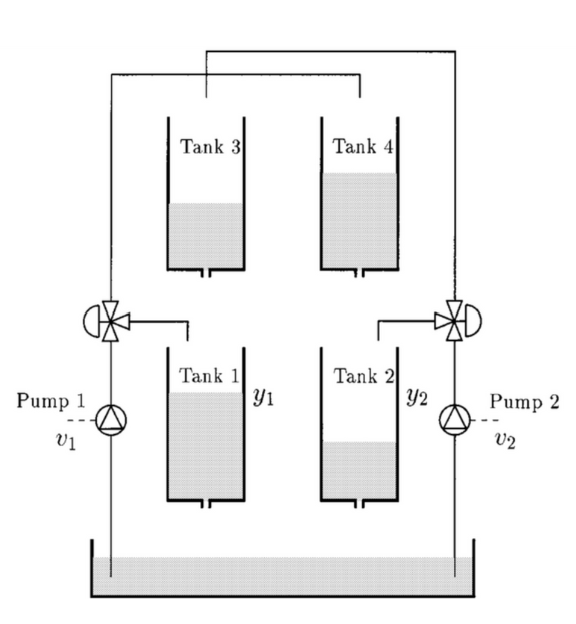

Let us consider the Quadruple-Tank Process. A schematic diagram of the process is shown in the Figure above. The
target is to control the level in the lower two tanks with two pumps. The process inputs are $v_1$ and $v_2$ (input voltages to the pumps) and the outputs are $y_1$ and $y_2$ (water levels in the lower two tanks). Mass balances and Bernoulli’s law yield:

$$
\dfrac{dh_1}{dt} = -\dfrac{a_1}{A_1}\sqrt{2gh_1} + \dfrac{a_3}{A_1}\sqrt{2gh_3} + \dfrac{\gamma_1k_1}{A_1}v_1 = f_1(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_2}{dt} = -\dfrac{a_2}{A_2}\sqrt{2gh_2} + \dfrac{a_4}{A_2}\sqrt{2gh_4} + \dfrac{\gamma_2k_2}{A_2}v_2 = f_2(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_3}{dt} = -\dfrac{a_3}{A_3}\sqrt{2gh_3} + \dfrac{(1-\gamma_2)k_2}{A_3}v_2 = f_3(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_4}{dt} = -\dfrac{a_4}{A_4}\sqrt{2gh_4} + \dfrac{(1-\gamma_1)k_1}{A_4}v_1 = f_4(h_1,h_2,h_3,h_4,v_1,v_2)
$$
where

$A_i$ is a cross-section of Tank i

$a_i$ is a cross-section of outlet hole of Tank i

$h_i$ is a water level.

The voltage applied to Pump $i$ is $v_i$ and the corresponding flow
is $k_iv_i$. The parameters $\gamma_1,\gamma_2\in (0,1)$ are determined from how the valves are set prior to the experiment. The flow to Tank 1
is $\gamma_1k_1v_1$ and the flow to Tank 4 is $(1-\gamma_1)k_1v_1$ and similarly
for Tank 2 and Tank 3. The acceleration of gravity is denoted $g$.
The measured level signals are $k_c h_1$ and $k_c h_2$. The parameter
values of the laboratory process are given in the following table

    A_1, A_3 [cm^2] 28
    A_2, A_4 [cm^2] 32
    a_1, a_3 [cm^2] 0.071
    a_2, a_4 [cm^2] 0.057
    k_c [V/cm] 0.50
    g [cm/s^2] 9.81
    k_1 [cm^3/Vs] 3.33
    k_2 [cm^3/Vs] 3.35
    gamma_1 0.70
    gamma_2 0.60
    
Check the following paper for more details on the model. 
https://www.diva-portal.org/smash/get/diva2:495784/FULLTEXT01.pdf
    

## TODO
1. Linearise the system around the operating point 
$$(h_1^0,h_2^0,h_3^0,h_4^0, v_1^0, v_2^0) = (12.4,12.7,1.8,1.4,3.00,3.00).$$
Pass to shifted variables $x_i = h_i-h_i^0, u_i = v_i - v_i^0.$

In [26]:
#profite from symbolic calculus do easy the math part
h1, h2, h3, h4, v1, v2, dh1, dh2, dh3, dh4 = sp.symbols('h1 h2 h3 h4 v1 v2 dh1 dh2 dh3 dh4')
A1, A3, A2, A4, a1, a3, a2, a4, kc, g, k1, k2, gamma1, gamma2 = sp.symbols('A1 A3 A2 A4 a1 a3 a2 a4 kc g k1 k2 gamma1 gamma2')

# Define the state-space representation of the system dynamics
f1 = -(a1/A1) * (2*g*h1)**(0.5) + (a3/A1) * (2*g*h3)**(0.5) + (gamma1*k1/A1) * v1
f2 = -(a2/A2) * (2*g*h2)**(0.5) + (a4/A2) * (2*g*h4)**(0.5) + (gamma2*k2/A2) * v2
f3 = -(a3/A3) * (2*g*h3)**(0.5) + ((1 - gamma2)*k2/A3) * v2
f4 = -(a4/A4) * (2*g*h4)**(0.5) + ((1 - gamma1)*k1/A4) * v1

f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([h1,h2,h3,h4])
variables_u = sp.Matrix([v1, v2])

# Compute the Jacobian matrices of the system

jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(h1,12.4), (h2,12.7), (h3, 1.8),(h4,1.4),(v1,3),(v2,3)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(h1,12.4), (h2,12.7), (h3, 1.8),(h4,1.4),(v1,3),(v2,3)]))

jacobian_A_s = sp.simplify(jacobian_A.subs([(A1, 28), (A3, 28),(A2,32),(A4,32),(a1,0.071),(a3,0.071),(a2,0.057),(a4,0.057),(kc,0.5),(g,9.81),(k1,3.33),(k2,3.35),(gamma1,0.7),(gamma2,0.6)]))
jacobian_B_s = sp.simplify(jacobian_B.subs([(A1, 28), (A3, 28),(A2,32),(A4,32),(a1,0.071),(a3,0.071),(a2,0.057),(a4,0.057),(kc,0.5),(g,9.81),(k1,3.33),(k2,3.35),(gamma1,0.7),(gamma2,0.6)]))

print('\nMatrix A (State matrix):')
print(jacobian_A_s)
print('\nMatrix B (Input matrix):')
print(jacobian_B_s)


Matrix A (State matrix):
Matrix([[-0.00159481011193197, 0, 0.00418584912630201, 0], [0, -0.00110698700509705, 0, 0.00333411338761495], [0, 0, -0.00418584912630201, 0], [0, 0, 0, -0.00333411338761495]])

Matrix B (Input matrix):
Matrix([[0.0832500000000000, 0], [0, 0.0628125000000000], [0, 0.0478571428571429], [0.0312187500000000, 0]])


2. Is the linear system controllable? Is the linear system observable? Use the Kalman rank test to answer this question.

In [27]:
import control as ct

# Convert SymPy matrices to NumPy arrays
A_np = np.array(jacobian_A_s).astype(float)
B_np = np.array(jacobian_B_s).astype(float)

C_np = np.array([[1, 0, 0, 0], 
                 [0, 1, 0, 0]]) 
D_np = np.zeros((2, 2))

sys = ct.ss(A_np, B_np, C_np, D_np)

# Controllability matrix
Wc = ct.ctrb(sys.A, sys.B)
print('Controllability Matrix:')
print(Wc)
print(f'\nRank of Wc: {np.linalg.matrix_rank(Wc)}')
print(f'System is controllable: {np.linalg.matrix_rank(Wc) == sys.A.shape[0]}')

# Observability matrix
Wo = ct.obsv(sys.A, sys.C)
print('\nObservability Matrix:')
print(Wo)
print(f'\nRank of Wo: {np.linalg.matrix_rank(Wo)}')
print(f'System is observable: {np.linalg.matrix_rank(Wo) == sys.A.shape[0]}')

Controllability Matrix:
[[ 8.32500000e-02  0.00000000e+00 -1.32767942e-04  2.00322780e-04
   2.11739656e-07 -1.15799773e-06 -3.37684545e-10  5.35670859e-09]
 [ 0.00000000e+00  6.28125000e-02  1.04086852e-04 -6.95326213e-05
  -4.62260161e-07  7.69717082e-08  1.66877792e-09 -8.52066807e-11]
 [ 0.00000000e+00  4.78571429e-02  0.00000000e+00 -2.00322780e-04
   0.00000000e+00  8.38520932e-07  0.00000000e+00 -3.50992211e-09]
 [ 3.12187500e-02  0.00000000e+00 -1.04086852e-04  0.00000000e+00
   3.47037368e-07  0.00000000e+00 -1.15706193e-09  0.00000000e+00]]

Rank of Wc: 4
System is controllable: True

Observability Matrix:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.59481011e-03  0.00000000e+00  4.18584913e-03  0.00000000e+00]
 [ 0.00000000e+00 -1.10698701e-03  0.00000000e+00  3.33411339e-03]
 [ 2.54341929e-06  0.00000000e+00 -2.41969674e-05  0.00000000e+00]
 [ 0.00000000e+00  1.22542023e-06  0.0000

3. Imagine that one of the pumps is broken and there is no flow through it. Does the system remain controllable?

In [28]:
#profite from symbolic calculus do easy the math part
import sympy as sp
import numpy as np
h1, h2, h3, h4, v1, v2, dh1, dh2, dh3, dh4 = sp.symbols('h1 h2 h3 h4 v1 v2 dh1 dh2 dh3 dh4')
A1, A3, A2, A4, a1, a3, a2, a4, kc, g, k1, k2, gamma1, gamma2 = sp.symbols('A1 A3 A2 A4 a1 a3 a2 a4 kc g k1 k2 gamma1 gamma2')

# Define the state-space representation of the system dynamics
f1 = -(a1/A1) * (2*g*h1)**(0.5) + (a3/A1) * (2*g*h3)**(0.5) 
f2 = -(a2/A2) * (2*g*h2)**(0.5) + (a4/A2) * (2*g*h4)**(0.5) + (gamma2*k2/A2) * v2
f3 = -(a3/A3) * (2*g*h3)**(0.5) + ((1 - gamma2)*k2/A3) * v2
f4 = -(a4/A4) * (2*g*h4)**(0.5) 

f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([h1,h2,h3,h4])
variables_u = sp.Matrix([v1, v2])

# Compute the Jacobian matrices of the system

jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(h1,12.4), (h2,12.7), (h3, 1.8),(h4,1.4),(v1,0),(v2,3)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(h1,12.4), (h2,12.7), (h3, 1.8),(h4,1.4),(v1,0),(v2,3)]))

jacobian_A_s = sp.simplify(jacobian_A.subs([(A1, 28), (A3, 28),(A2,32),(A4,32),(a1,0.071),(a3,0.071),(a2,0.057),(a4,0.057),(kc,0.5),(g,9.81),(k1,3.33),(k2,3.35),(gamma1,0.7),(gamma2,0.6)]))
jacobian_B_s = sp.simplify(jacobian_B.subs([(A1, 28), (A3, 28),(A2,32),(A4,32),(a1,0.071),(a3,0.071),(a2,0.057),(a4,0.057),(kc,0.5),(g,9.81),(k1,3.33),(k2,3.35),(gamma1,0.7),(gamma2,0.6)]))

print('\nMatrix A (State matrix):')
print(jacobian_A_s)
print('\nMatrix B (Input matrix):')
print(jacobian_B_s)

C_np = np.array([[1, 0, 0, 0], 
                 [0, 1, 0, 0]]) 
D_np = np.zeros((2, 2))

Wc = ct.ctrb(jacobian_A_s, jacobian_B_s)

rank_Wc = np.linalg.matrix_rank(Wc)
n = jacobian_A_s.shape[0] 

if rank_Wc == n:
    print("The system is controlable.")
else:
    print("The system is not completaly controlable.")




Matrix A (State matrix):
Matrix([[-0.00159481011193197, 0, 0.00418584912630201, 0], [0, -0.00110698700509705, 0, 0.00333411338761495], [0, 0, -0.00418584912630201, 0], [0, 0, 0, -0.00333411338761495]])

Matrix B (Input matrix):
Matrix([[0, 0], [0, 0.0628125000000000], [0, 0.0478571428571429], [0, 0]])
The system is not completaly controlable.


4. Let us measure the signals $x_3, x_4$ (i.e. matrix $C = \begin{pmatrix}0&0&1&0\\0&0&0&1\end{pmatrix}$) instead of measuring the signals $x_1$ and $x_2.$ Is such a system observable?

In [29]:
C_np = np.array([[0, 0, 1, 0], 
                 [0, 0, 0, 1]]) 

n = jacobian_A_s.shape[0] 

Wo = ct.obsv(jacobian_A_s, C_np)
rank_Wo = np.linalg.matrix_rank(Wo)

if rank_Wo == n:
    print("The system is observable.")
else:
    print("The system is not observable.")


The system is not observable.


**Remark.** The functions control.ctrb and control.obsv from the control system library might be useful to complete this exercise. https://python-control.readthedocs.io/en/0.10.1/generated/control.obsv.html 